<span style="font-family: Arial; font-weight:bold;font-size:2em;color:#00b3e5;"> SMS spam ham detection
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Submitted by
    
<span style="font-family: Arial; font-weight:bold;font-size:1.5em;color:#00b3e5;"> Shameer.Sutar


## <div style="background-color:#F3C130;font-size:20px;padding:10px 10px;color:black;border:4px solid #1C1B20"> Importing Libraries</div>l

In [32]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## <div style="background-color:#F3C130;font-size:20px;padding:10px 10px;color:black;border:4px solid #1C1B20"> Loading data</div>l

In [15]:
data = pd.read_csv("spam.csv",encoding='latin')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
# Drop unnecessary columns
data = data[['v1', 'v2']]

# Rename columns for clarity
data.columns = ['Label', 'Message']

# Display the cleaned dataset
print(data.head())


  Label                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [17]:
# Check for null values in the dataset
print("Null Values:")
print(data.isnull().sum())


Null Values:
Label      0
Message    0
dtype: int64


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [19]:
data.describe()

,Label,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


## <div style="background-color:#F3C130;font-size:20px;padding:10px 10px;color:black;border:4px solid #1C1B20"> EDA </div>l

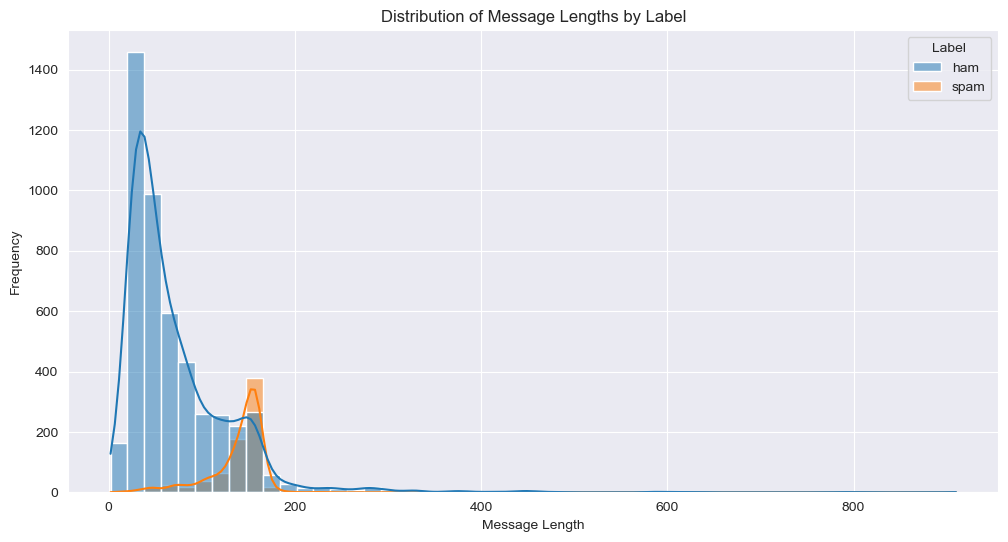

In [29]:
# Add a column for message lengths
data['Message_Length'] = data['Message'].apply(len)

# EDA: Message Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data, x='Message_Length', hue='Label', bins=50, kde=True)
plt.title('Distribution of Message Lengths by Label')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()


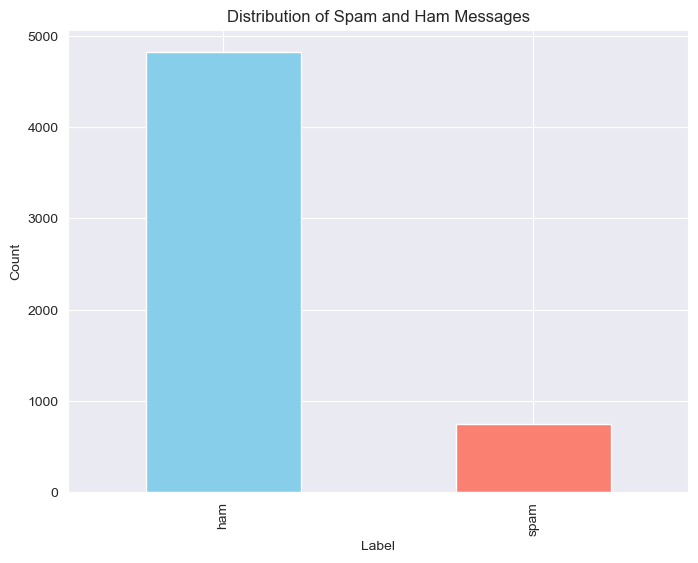

In [30]:
# EDA: Distribution of Spam and Ham Messages
plt.figure(figsize=(8, 6))
data['Label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


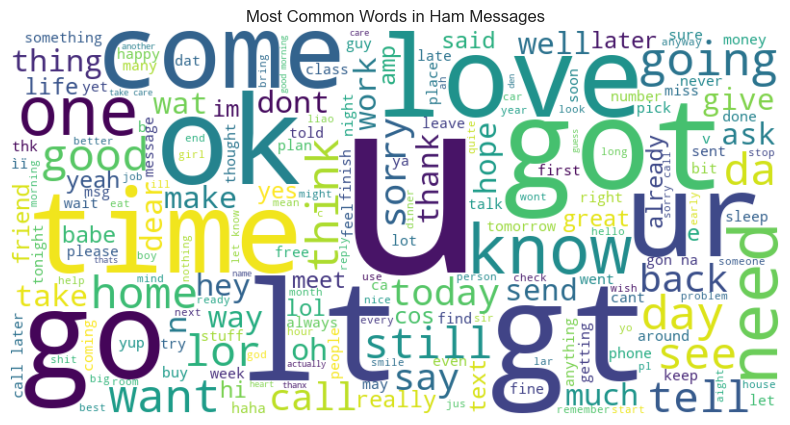

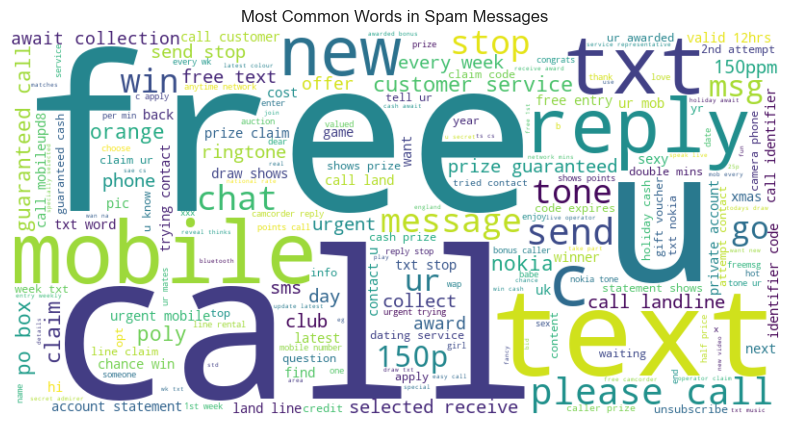

In [33]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Function to plot most common words
def plot_most_common_words(text, label, n=10):
    words = ' '.join(text)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words in {label} Messages')
    plt.axis('off')
    plt.show()

# Most Common Words in Ham Messages
plot_most_common_words(data[data['Label'] == 'ham']['Message_Preprocessed'], 'Ham')

# Most Common Words in Spam Messages
plot_most_common_words(data[data['Label'] == 'spam']['Message_Preprocessed'], 'Spam')


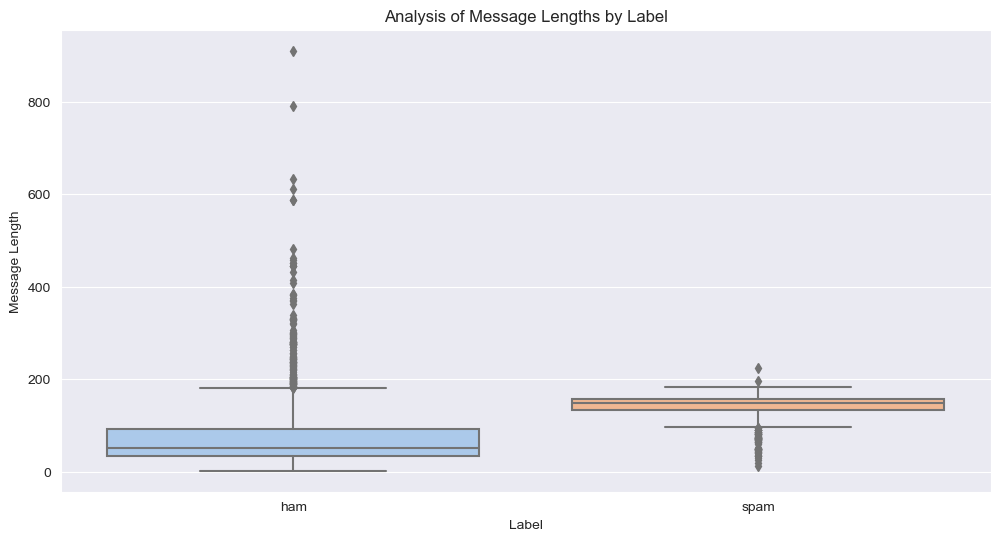

In [34]:
# EDA: Analysis of Message Lengths
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Message_Length', data=data, palette='pastel')
plt.title('Analysis of Message Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Message Length')
plt.show()


## <div style="background-color:#F3C130;font-size:20px;padding:10px 10px;color:black;border:4px solid #1C1B20">Text preprocessing </div>l

In [20]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Download NLTK resources (run once)
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

# Function for text preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove punctuation and non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply text preprocessing to the messages
data['Message_Preprocessed'] = data['Message'].apply(preprocess_text)

# Display the preprocessed text for the first few rows
print(pd.concat([data['Label'], data['Message_Preprocessed']], axis=1).head())


  Label                               Message_Preprocessed
0   ham  go jurong point crazy available bugis n great ...
1   ham                            ok lar joking wif u oni
2  spam  free entry 2 wkly comp win fa cup final tkts 2...
3   ham                u dun say early hor u c already say
4   ham             nah think goes usf lives around though


In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the training set
X_train_vectorized = vectorizer.fit_transform(data['Message_Preprocessed'])

# Display the vocabulary size
print("Vocabulary Size:", len(vectorizer.get_feature_names_out()))


Vocabulary Size: 8002


## <div style="background-color:#F3C130;font-size:20px;padding:10px 10px;color:black;border:4px solid #1C1B20">Model Building </div>l

In [24]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_vectorized, data['Label'], test_size=0.2, random_state=42)

# Initialize the Naive Bayes model
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9668161434977578

Classification Report:
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       965
        spam       0.86      0.89      0.88       150

    accuracy                           0.97      1115
   macro avg       0.92      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



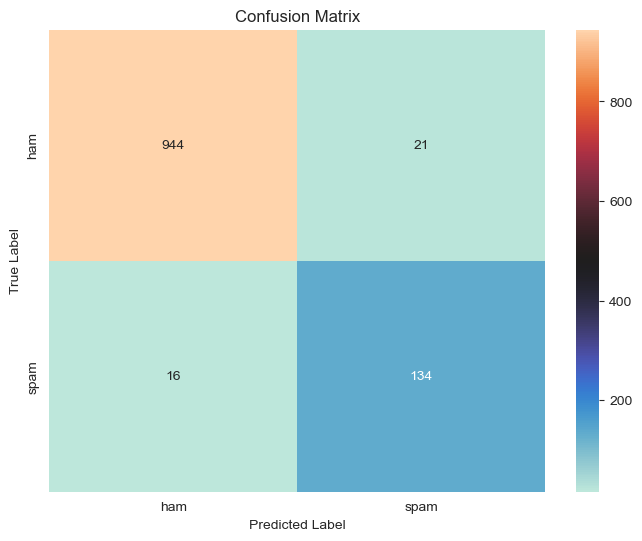

In [26]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="icefire", xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [28]:
# Create a DataFrame with actual and predicted labels
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Display the first few rows of the DataFrame
print(predictions_df.head())


     Actual Predicted
3245    ham      spam
944     ham       ham
1044   spam      spam
2484    ham       ham
812    spam      spam
